In [1]:
# Importing standard libraries for every machine/deep learning pipeline
import pandas as pd
import torch
from tqdm import tqdm, trange
import numpy as np

# Importing specific libraries for data prerpcessing, model archtecture choice, training and evaluation
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW
import sentencepiece

In [2]:
# Defining constants
MAX_LEN = 256 # i.e le max supproter par BERT (par heritage) is 512ne
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU T4 google drive
print(device)

cuda


# Chargement des données

In [3]:
data = {
    'train' : None,
    'val' : None,
    'test' : None
}
for df_name in data.keys():
    data[df_name] = pd.read_csv(f"{df_name}.csv", sep='~')

# Encoding

In [4]:
# Load Camembert tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
pad_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
print('Pad id', pad_id)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Pad id 1


In [5]:
def encode(text : str)->list:
    input_id = tokenizer.encode(text, add_special_tokens=True,max_length=MAX_LEN-2, truncation=True)
    # padding
    input_id += [pad_id for _ in range(MAX_LEN-len(input_id))]
    return input_id

def get_attention_masks(input_id : list)->list:
    return [1 if id_ != pad_id else 0 for id_ in input_id]

In [6]:
def create_inputs(df : pd.DataFrame)->TensorDataset:
    input_ids = [encode(df['contenu'].iloc[i]) for i in range(df.shape[0])]
    attention_masks = [get_attention_masks(input_id) for input_id in input_ids]
    labels = list(df['sentiment'])

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_masks, labels)

# Create Dataset

In [7]:
# train
train_data = create_inputs(data['train'])
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [8]:
# val
validation_data = create_inputs(data['val'])
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
# test on fera plus tard pour par trop surcharge

# Le model CamemBert

In [9]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
# init mal les poids, force a les isntancier
state_dict = CamembertForSequenceClassification.from_pretrained("camembert-base").state_dict()
model.load_state_dict(state_dict)
model.to(device)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

# Les paramètres

In [10]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training

In [11]:
epochs = 5

In [12]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []
train_scores, test_scores = [], [] # loss
# trange is a tqdm wrapper around the normal python range
for e in range(epochs):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the model
    model.train()
    for step, batch in tqdm(enumerate(train_dataloader), desc=f"Training - epoch {e}, {len(train_dataloader)} batchs"):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_scores.append(tr_loss/nb_tr_steps)


    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader,  desc=f"Validation - epoch {e}, {len(validation_dataloader)} batchs"):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
            eval_loss += loss

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

    test_scores.append(eval_loss/nb_eval_steps)

Training - epoch 0, 498 batchs: 498it [05:16,  1.58it/s]


Train loss: 0.30966796458186396


Validation - epoch 0, 166 batchs: 100%|██████████| 166/166 [00:32<00:00,  5.15it/s]


Validation Accuracy: 0.9051204819277109


Training - epoch 1, 498 batchs: 498it [05:21,  1.55it/s]


Train loss: 0.1781922933462274


Validation - epoch 1, 166 batchs: 100%|██████████| 166/166 [00:32<00:00,  5.15it/s]


Validation Accuracy: 0.9058734939759037


Training - epoch 2, 498 batchs: 498it [05:22,  1.55it/s]


Train loss: 0.11258754691008074


Validation - epoch 2, 166 batchs: 100%|██████████| 166/166 [00:32<00:00,  5.17it/s]


Validation Accuracy: 0.9051204819277109


Training - epoch 3, 498 batchs: 498it [05:21,  1.55it/s]


Train loss: 0.06840340875044286


Validation - epoch 3, 166 batchs: 100%|██████████| 166/166 [00:32<00:00,  5.15it/s]


Validation Accuracy: 0.9002259036144579


Training - epoch 4, 498 batchs: 498it [05:21,  1.55it/s]


Train loss: 0.05075367429736912


Validation - epoch 4, 166 batchs: 100%|██████████| 166/166 [00:32<00:00,  5.16it/s]

Validation Accuracy: 0.8900602409638554


In [13]:
import matplotlib.pyplot as plt
def plot_learning_curves(epochs, train_scores, test_scores, figsize=(10,7), fontsize=14):
    train_scores = np.array(train_scores) # loss
    test_scores = np.array(test_scores)

    fig = plt.figure(figsize=figsize)

    # Draw lines
    plt.plot(epochs, train_scores, '--', color="r",  label="Training loss")
    plt.plot(epochs, test_scores, color="g", label="Validation loss")


    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(loc="lower right")

    return fig

In [24]:
train_scores = [float(s) for s in train_scores]
test_scores = [float(s)/len(validation_dataloader) for s in test_scores]

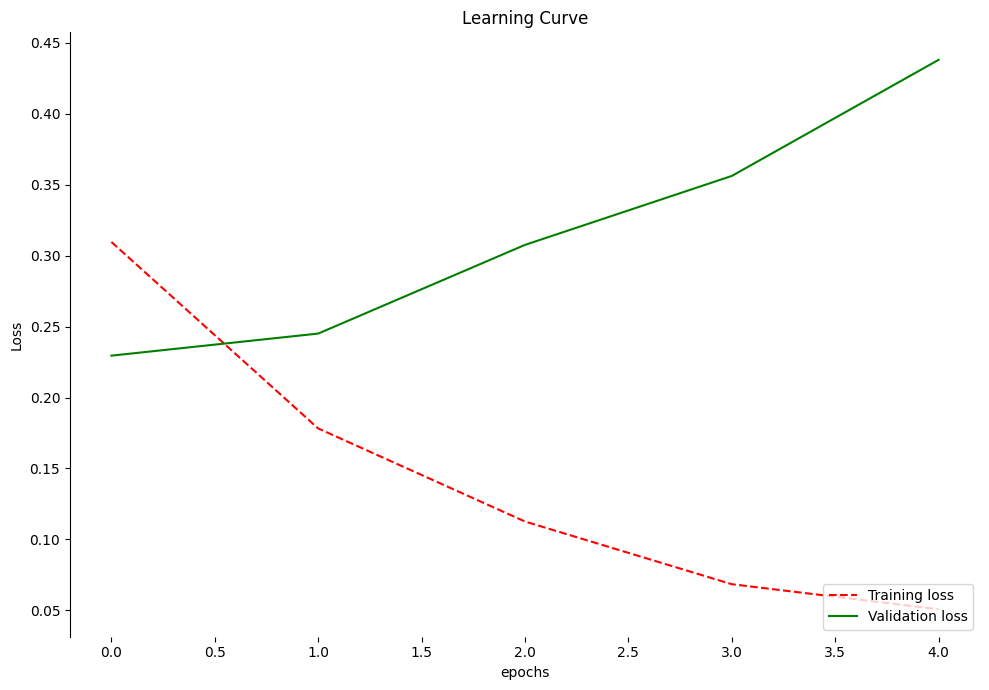

In [27]:
import seaborn as sns
fig = plot_learning_curves(range(epochs), train_scores, test_scores)
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Test et Save

## Save

In [28]:
# Save the model
model.save_pretrained("camembert")

## Test

In [52]:
batch_size = 1

In [60]:
# test
test_data = create_inputs(data['test'])
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [61]:
model.eval()
flat_pred = []
for batch in tqdm(test_dataloader,  desc=f"Inference, {len(test_dataloader)} batchs"):
  # Add batch to device CPU or GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      flat_pred.extend(np.argmax(logits, axis=1).flatten())


Inference, 2654 batchs: 100%|██████████| 2654/2654 [00:44<00:00, 60.22it/s]


In [62]:
map_sentiments = {
    0 : 'negatif',
    1 : 'positif'
}

In [63]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_pred = np.array(flat_pred)
y_test = np.array(data['test']['sentiment'])

print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))

report = metrics.classification_report(
    y_test, y_pred,
    target_names=map_sentiments.values()
)
print(report)

Test Accuracy: 89.56
Test F1-Score: 90.53
              precision    recall  f1-score   support

     negatif       0.85      0.93      0.88      1138
     positif       0.94      0.87      0.91      1516

    accuracy                           0.90      2654
   macro avg       0.89      0.90      0.89      2654
weighted avg       0.90      0.90      0.90      2654



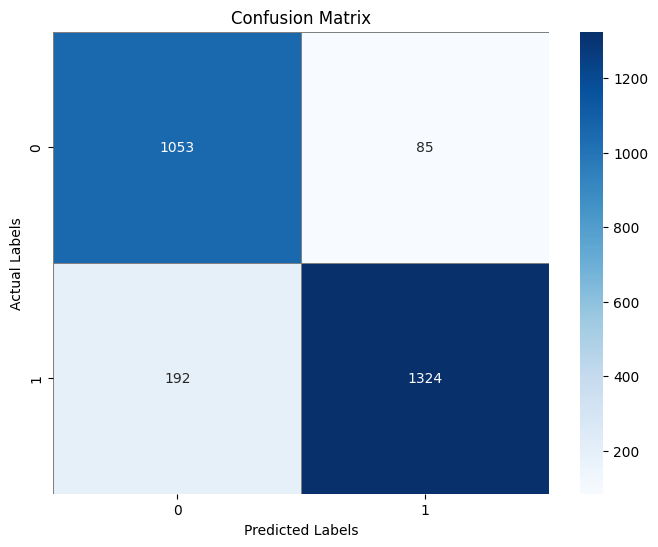

In [64]:
conf_mx = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mx, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray')

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.savefig('confusion_test.png')
plt.show()

## Temps d'éxecution

In [65]:
device = torch.device('cpu') # meme config que pour tf-idf
device

device(type='cpu')

In [66]:
model.to(device)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

In [67]:
import time
model.eval()
flat_pred = []
ex_times = []
for batch in tqdm(test_dataloader,  desc=f"Inference, {len(test_dataloader)} batchs"):
  # Add batch to device CPU or GPU
  start = time.time()
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      end = time.time()
      ex_times.append(end-start)
      flat_pred.extend(np.argmax(logits, axis=1).flatten())
  if len(flat_pred) == 1000:
    break

Inference, 2654 batchs:  38%|███▊      | 999/2654 [12:40<20:59,  1.31it/s]


In [68]:
import pickle
with open('camembert_times.pickle', 'wb') as writer:
    pickle.dump(ex_times, writer)

# Comparaison temps d'inférence entre TF-IDF classifier et Camembert

In [19]:
def add_times_to_df(path, df, model_name):
    with open(path, 'rb') as reader:
        times = pickle.load(reader)
        df = df.append(
            pd.DataFrame([[model_name, 1000*time] for time in times], columns=["model", "times"]),
            ignore_index=True
        )
    return df

time_data = pd.DataFrame()

time_data = add_times_to_df(
    'models/tf-idf/tfidf_times.pickle',
    time_data, 'TF-IDF')

time_data = add_times_to_df(
    'models\camembert\camembert_times.pickle',
    time_data, 'CamemBERT')

C:\Users\matte\AppData\Local\Temp\ipykernel_18028\1679508828.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
C:\Users\matte\AppData\Local\Temp\ipykernel_18028\1679508828.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(


C:\Users\matte\AppData\Local\Temp\ipykernel_18028\56006145.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='model', y='times', data=time_data, ci=None) # capsize=.2)


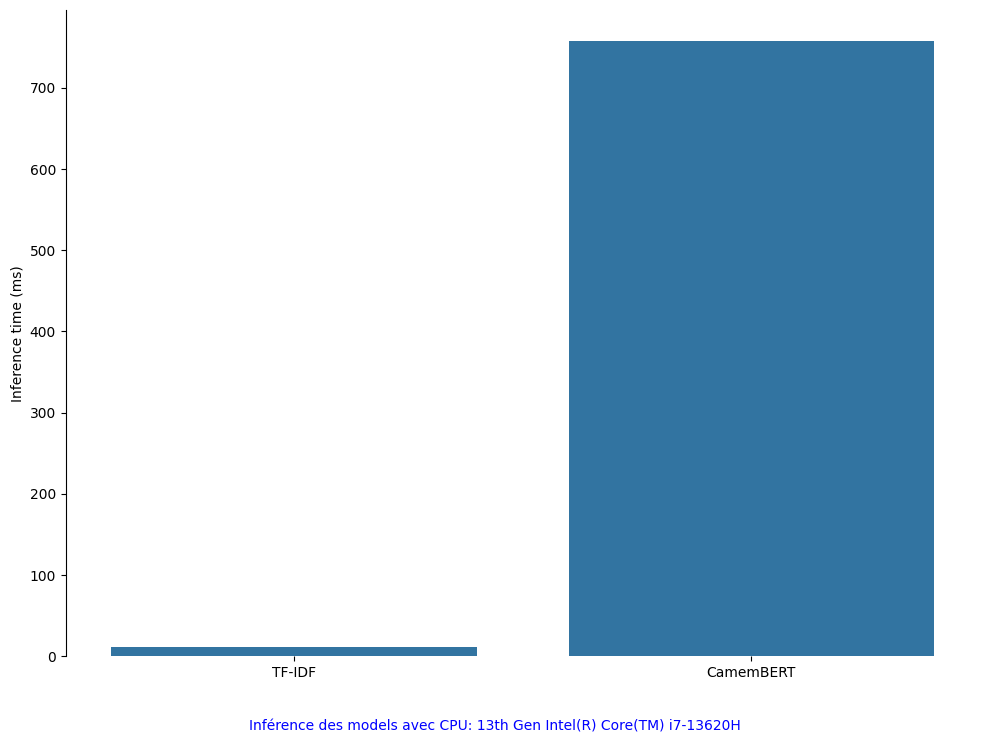

In [20]:
fig = plt.figure(figsize=(10,7))

plt.figtext(.5, -0.05, 'Inférence des models avec CPU: 13th Gen Intel(R) Core(TM) i7-13620H', ha='center', color='b')

sns.barplot(x='model', y='times', data=time_data, ci=None) # capsize=.2)
plt.xlabel('')
plt.ylabel('Inference time (ms)')

# Text

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=10)

# Saving plot
fig.savefig('img/inference_time.png')